# Community GO Enrichment Analysis

Here I perform Gene Ontology enrichment analysis on each of the 577 communities produced by the infomap community detection algorithm, detailed in the following notebook:

https://github.com/wigasper/viral-mirna-database/blobl/master/exploratory_network_analysis.md

I am interested in the what proportion of community members share any significantly enriched Gene Ontology terms. This may provide insight as to why target genes or communities of target genes ended up as targets of Epstein-Barr virus, and it also may potentially serve as validation for community detection algorithms. Some of this is fairly intuitive and to be expected: proteins that interact with each other tend to be part of the same biological processes and located in the same locations. Thus, it could be expected that each community will have significantly enriched GO terms, and many members of each community will share some of these significantly enriched GO terms.

I used the [GOATools package](https://github.com/tanghaibao/goatools) with their [Run a Gene Ontology Enrichment Analysis notebook](https://github.com/tanghaibao/goatools/blob/master/notebooks/goea_nbt3102.ipynb) as a guide to help me get started and provide some code.

In [ ]:
import psycopg2
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as gene_id_2_nt
from goatools.go_enrichment import GOEnrichmentStudy

## Conversion of Gene Symbols to Gene IDs
I conducted my [exploratory analysis](https://github.com/wigasper/viral-mirna-database/blobl/master/exploratory_network_analysis.md) using gene symbols, and I needed to convert these to gene IDs to play nicely with GOATools. To do this I used psycopg2 to query my database (which contains both symbols and gene IDs for genes) and made a dictionary to do the conversion.

In [43]:
# Create connection
conn = psycopg2.connect(database="vir_mirna", user="wkg", 
                        password="apples", host="localhost")

# Create cursor
cursor = conn.cursor()

# Query
cursor.execute("SELECT interactor_a_symbol, interactor_a_gene_id "
               "FROM protein_interaction ;")

results = cursor.fetchall()

# Make dict
gene_to_symbol = dict(results)

# Query - I want to query both interactors for my conversion dict
# to ensure that I am not missing anything
cursor.execute("SELECT interactor_b_symbol, interactor_b_gene_id "
               "FROM protein_interaction ;")

results = cursor.fetchall()

# Update dict
gene_to_symbol.update(dict(results))

## Read in Community Data

In [46]:
# Read in membership data and convert to symbols to gene IDs
membership = []
with open("./data/protein_community_membership.csv", "r") as fp:
    for line in fp:
        if not line.startswith("symbol"):
            line = line.strip("\n")
            line = line.split(",")
            
            if gene_to_symbol[line[0]] is not None:
                membership.append([gene_to_symbol[line[0]], int(line[1])])

# Extract community IDs
communities = [comm[1] for comm in membership]
# Remove duplicates
communities = list(dict.fromkeys(communities))

## GO Enrichment Analysis Setup

In [ ]:
obodag = GODag("./data/go.obo")
geneid2gos = read_ncbi_gene2go("./data/gene2go", taxids=[9606])

goeaobj = GOEnrichmentStudy(
        gene_id_2_nt.keys(), # human protein coding genes
        geneid2gos, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

In [ ]:
# Run GO enrichment analysis for each community
comm_enrich_scores = []
for community in communities:
    subset = [gene[0] for gene in membership if gene[1] == community]

    # Exclude communities smaller than 5:
    if len(subset) > 5:
        goea_results = goeaobj.run_study(subset);
        sig_results = [result for result in goea_results if result.p_fdr_bh < 0.05]

        enriched_mem_ratios = []
        for res in sig_results:
            enriched_mem_ratios.append(res.ratio_in_study[0] / res.ratio_in_study[1])

        if len(enriched_mem_ratios):
            avg_enriched_ratio = sum(enriched_mem_ratios) / len(enriched_mem_ratios)
            comm_enrich_scores.append([community, avg_enriched_ratio])

## Community Enrichment Analysis Results

First, let's see how many of our communities contain members with significantly enriched GO terms:

In [49]:
print(str(len(comm_enrich_scores) / len(communities)))

0.4067796610169492


Not terribly promising, but I don't really have any basis for evaluation here. In the future I would like to try a number of different community detection algorithms with a variety of parameters to get a better idea for what this could look like. I also do not have enough experience to know whether or not a "good" community always has enriched GO terms - it intuitively seems like it might, but this might not be the case.

We can use a kernel density plot to help visualize the results of performing GO enrichment analysis on each community. This graph shows the distribution of relative term enrichment frequencies, where a relative term enrichment frequency is the average frequency of community members that contained significantly enriched GO terms. As mentioned earlier, we might expect community members to contain similar GO terms, because proteins tend to interact with other proteins involved in the same processes.

This basic method could be expanded and made significantly more robust in order to evaluate community detection algorithms. 

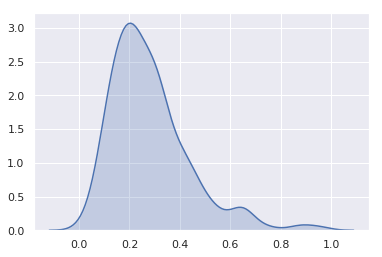

In [52]:
import seaborn as sns
#import numpy as np

freqs = [score[1] for score in comm_enrich_scores]
#freqs = np.array(freqs)

sns.set(color_codes=True)
sns.kdeplot(freqs, shade=True)
#sns.distplot(freqs)

Let's also find the frequency of communities where greater than 50% of community members shared significantly enriched GO terms:

In [53]:
print(str(len([comm for comm in comm_enrich_scores if comm[1] >= .5]) / len(comm_enrich_scores)))

0.0875


There seems to be a lot of room for improvement here. In the future, I would like to test out additional community detection algorithms on different subsets of the protein interactome in order to see what kind of outcomes or normal for GO enrichment analysis of communities. For the scope of this project, which is primarily about database design and implementation and has a short time frame, this outcome is acceptable.